# CS342 Coursework
## u1905486

## (A) Import Data

Import Iris dataset

In [1]:
# import relevant libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: IMPORT DATA INTO IRIS WITH CORRECT PATH TO FILE
iris = pd.read_csv('iris.data',
                  names=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth", "Class"])

## Centre Columns of Data

Centre the columns of the dataframe by calculating each features mean and subracting it from each value in that feature.

In [2]:
# remove the target column from iris
iris1 = iris.drop(['Class'], axis=1)
# centre data by subtracting mean of each column from values in that column
iris2 = iris1 - iris1.mean()

## (B) Use SVD to Calculate PCA

Use _numpy.linalg.svd_ implementation to calculate the SVD which we can use to get the PC's we want.

In [3]:
u, s, v = np.linalg.svd(iris2, full_matrices=True)
labels= ['PC1','PC2']

# new co-ordinates of observations calculated by multilplying first 2 rows of u and s 
## as we want 2 most important principal components
PCs = u[:,0:2]*s[0:2]

# set svd equal to a dataframe with true values
## and first two columns of u mutliplied by first two columns of s (first two PC's)
svd = pd.DataFrame(PCs, index=iris["Class"].tolist(), columns=labels)
svd = svd.reset_index()
svd.rename(columns={'index':'Class'}, inplace=True)

## Create Scatterplot for PC's

Text(0, 0.5, 'PC 2')

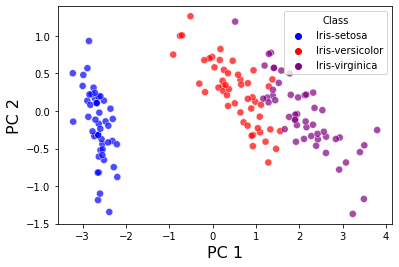

In [4]:
# colours for each class
color_dict = dict({'Iris-setosa':'Blue',
                   'Iris-versicolor':'Red',
                   'Iris-virginica':'Purple'})

# scatter plot
sns.scatterplot(x="PC1", y="PC2", hue="Class", 
                palette=color_dict, data=svd,
                s=50, alpha=0.7)
plt.xlabel('PC 1', fontsize=16)
plt.ylabel('PC 2', fontsize=16)

## (C1) K-means Clustering

(-4.0, 4.0)

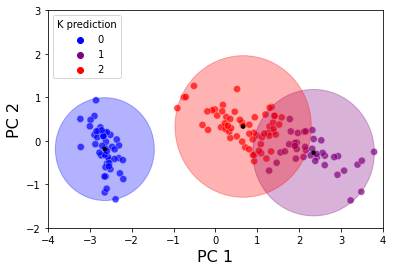

In [5]:
from sklearn.cluster import KMeans

# use python implementation to find k-means for 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(PCs)

# make a dataframe with co-ordinates of points and k-means predictions
svd = pd.DataFrame(PCs, index=kmeans.labels_, columns=labels)
svd = svd.reset_index()
svd.rename(columns={'index':'K prediction'}, inplace=True)

# colours for each class
color_dict = dict({0:'Blue',
                   2:'Red',
                   1:'Purple'})

# scatter plot
sns.scatterplot(x="PC1", y="PC2", hue="K prediction", 
                palette=color_dict, data=svd,
                s=50, alpha=0.7)
plt.xlabel('PC 1', fontsize=16)
plt.ylabel('PC 2', fontsize=16)

# compute centre of each cluster
mu = kmeans.cluster_centers_

def distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# compute radius of each cluster
rad = [0]*3
for i in range(150):
    for c in range(3):
        if kmeans.labels_[i] == c:
            d = distance(PCs[i], mu[c])
            if d > rad[c]:
                rad[c] = d
                break

# draw circles around each cluster for k means using mu and radii
circle1 = plt.Circle(mu[0], rad[0], color='blue', alpha = 0.3)
centre1 = plt.Circle(mu[0], 0.04, color='black', alpha = 1) #centre of cluster

circle2 = plt.Circle(mu[1], rad[1], color='purple', alpha = 0.3)
centre2 = plt.Circle(mu[1], 0.04, color='black', alpha = 1)

circle3 = plt.Circle(mu[2], rad[2], color='red', alpha = 0.3)
centre3 = plt.Circle(mu[2], 0.04, color='black', alpha = 1)

fig = plt.gcf()
ax = fig.gca()

ax.add_patch(circle1); ax.add_patch(centre1)
ax.add_patch(circle2); ax.add_patch(centre2)
ax.add_patch(circle3); ax.add_patch(centre3)

ax.set_ylim(-2,3)
ax.set_xlim(-4,4)

## Accuracy of k-means

In [6]:
import statistics as st
# calculates accuracy of predictions as a decimal
def accuracy(pred, true):
    accuracy = 0
    for i in range(150):
        if pred[i] == true[i]:
            accuracy += 1/150
    return accuracy

# set true values so they can be compared to predicted
true = [0]*150 #initialise true values
set_lab = st.mode(kmeans.labels_[0:50]) #find value kmeans assigned to setosa
vers_lab = st.mode(kmeans.labels_[50:100]) #find value kmeans assigned to versicolor
vir_lab = st.mode(kmeans.labels_[100:150]) #ind value kmeans assigned to virginica

for i in range(150):
    if iris["Class"][i] == "Iris-versicolor":
        true[i] = vers_lab
    elif iris["Class"][i] == "Iris-virginica":
        true[i] = vir_lab
    else:
        true[i] = set_lab

# caluclate accuracy of k-means algorithm as a decimal
accuracy_K = accuracy(kmeans.labels_, true)
print(accuracy_K)

0.8866666666666685


## Use sklearn k-means to Find Initial Parameters for EM Algorithm

In [7]:
# find the number of observations from each cluster
unique, counts = np.unique(kmeans.labels_, return_counts=True)

# pi initialised as the amount of observations belonging to each cluster
pi = [counts[0]/150, counts[1]/150, counts[2]/150]

# mean of each cluster as mu calculated above (mu = kmeans.cluster_centers_)
mu

# covariance matrix calculated for each cluster using k-means
sigma = [pd.DataFrame(PCs[kmeans.labels_ == c]).cov() for c in range(3)]

## (C2/C3) Compute Responsibilites and Compute Expectation and Maximization steps

Calculate the reposibilites for each observation, the probability it belongs to each cluster.

In [8]:
from scipy.stats import multivariate_normal

iterations = 21 #set amount of iterations to run for
respon = np.zeros((150,3)) #initialise responsibilites
negLogLik = [0]*iterations #initialise negative log-likelihood

for iteration in range(iterations):
    N = [0]*3
    
    # for ith observation
    for i in range(150):
        dnt = 0
        # for cth cluster
        normals = [pi[c]*multivariate_normal(mu[c], sigma[c]).pdf(PCs[i]) for c in range(3)]
        dnt = sum(normals) #denominator for equation 15
        negLogLik[iteration] -= np.log(dnt) #adds to the negative log-likelihood (C3)
        for c in range(3):
            respon[i][c] = normals[c]/dnt #calculates responsibilities
            N[c] += normals[c]/dnt #sum of responsibilities for each cluster

    for c in range(3):
        pi[c] = N[c]/150 #update pi as a fraction of clusters repsonsibility
        mt = np.array([0, 0])
        st = np.array([0, 0])
        for i in range(150):
            mt = mt + np.array(respon[i][c]*PCs[i]) #sum of responsibilities multiplied by PCs for each cluster
        mu[c] = (1/N[c])*mt #update mu by dividing the sum of respon*PCs by sum of responsibilities for that cluster
        for i in range(150):
            mat = np.array(PCs[i]) - np.array(mu[c])
            st = st + respon[i][c]*(np.matmul(mat.reshape(2,1), mat.reshape(1, 2)))
        sigma[c] = (1/N[c])*st #update sigma using formula for covariance matrix

## (C3) Covergence

converges in  19  iterations


Text(0, 0.5, 'Negative Log-likelihood')

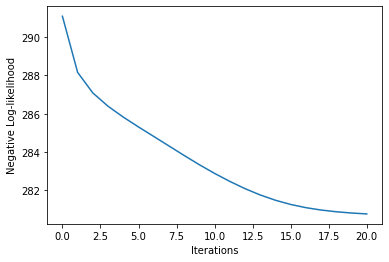

In [9]:
# gives the iteration at which the next iteration would only decrease negative log-likelihood by a convergenceAmount
convergenceAmount = 0.05
for x in range(iterations):
    if negLogLik[x] - negLogLik[x+1] < convergenceAmount:
        print("converges in ", x, " iterations")
        break
        
plt.plot(negLogLik)
plt.xlabel("Iterations")
plt.ylabel("Negative Log-likelihood")

## (C4) Final Parameters

In [10]:
print("pi: ", "\n", pi, "\n")
print("mu: ", "\n", mu, "\n")
print("sigma: ", "\n", sigma[0], "\n")
print(sigma[1], "\n")
print(sigma[2])

pi:  
 [0.33333333333332693, 0.3598545259714582, 0.30681214069521484] 

mu:  
 [[-2.64084076 -0.19051995]
 [ 2.01611959 -0.015903  ]
 [ 0.5044471   0.22564106]] 

sigma:  
 [[ 0.04777048 -0.05590782]
 [-0.05590782  0.21472356]] 

[[ 0.56722846 -0.29337591]
 [-0.29337591  0.23167306]] 

[[ 0.36231947 -0.21800689]
 [-0.21800689  0.18863075]]


## Plot EM Algorithm Clusters

In [11]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

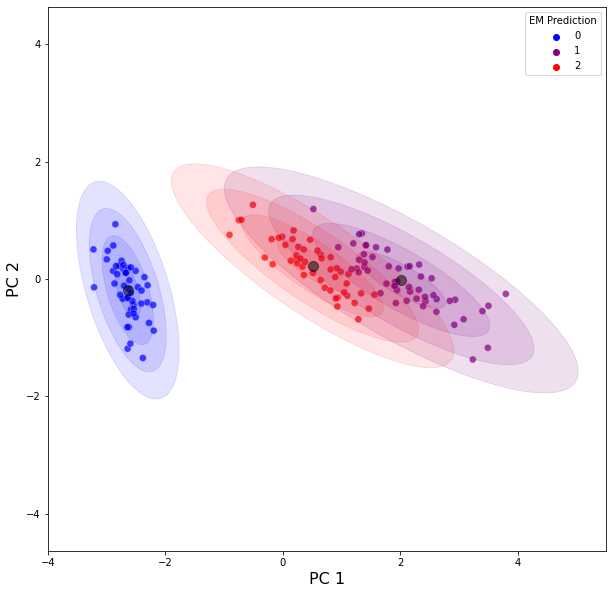

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.axis('equal')

# find predicted values
pred_EM = [0]*150
for i in range(150):
    m = max(respon[i])
    for c in range(3):
        if respon[i][c] == m:
            pred_EM[i] = c
            break
            
# make a dataframe with co-ordinates of points and EM predictions
svd = pd.DataFrame(PCs, index=pred_EM, columns=labels)
svd = svd.reset_index()
svd.rename(columns={'index':'EM Prediction'}, inplace=True)

# colours for each class
color_dict = dict({0:'Blue',
                   2:'Red',
                   1:'Purple'})

# scatter plot
sns.scatterplot(x="PC1", y="PC2", hue="EM Prediction", 
                palette=color_dict, data=svd,
                s=50, alpha=0.7)
plt.xlabel('PC 1', fontsize=16)
plt.ylabel('PC 2', fontsize=16)
plt.ylim(-3, 3)
plt.xlim(-4, 5.5)

# ellipse 1
pos = mu[0] #center of ellipse (point of highest probability)
covar = sigma[0] #shape of ellipse
alpha_factor = pi[0]/3;  #controls transparency of displayed ellipse to simulate region of probability
plt.scatter(pos[0],pos[1],c='black', s=100, alpha=0.5, zorder=2); #draw center of ellipse
draw_ellipse(pos, covar, alpha = alpha_factor, color = "blue")

# ellipse 2
pos = mu[1]
covar= sigma[1]
alpha_factor = pi[1]/3;  
plt.scatter(pos[0],pos[1],c='black', s=100, alpha=0.5, zorder=2);
draw_ellipse(pos, covar, alpha = alpha_factor, color = "purple")

# ellipse 3
pos = mu[2]
covar= sigma[2]
alpha_factor = pi[2]/3;
plt.scatter(pos[0],pos[1],c='black', s=100, alpha=0.5, zorder=2);
draw_ellipse(pos, covar, alpha = alpha_factor, color = "red")

## (C5) Accuracy of EM

In [13]:
# caluclate accuracy of EM algorithm as a decimal
accuracy_EM = accuracy(pred_EM, true)
print(accuracy_EM)

0.9800000000000024
